# Solución del problema de Henry

Ecuaciones gobernantes:

$$
\frac{\partial^2\Psi}{\partial x^2} + \frac{\partial^2\Psi}{\partial y^2}
=
\frac{1}{a}\frac{\partial C}{\partial x}
\\
\frac{\partial^2 C}{\partial x^2} + \frac{\partial^2 C}{\partial y^2}
- \frac{1}{b}
\left(
	\frac{\partial \Psi}{\partial y}\frac{\partial C}{\partial x}
	-
	\frac{\partial \Psi}{\partial x}\frac{\partial C}{\partial y}
\right)
=
\frac{\partial C}{\partial t}
$$

Condiciones de frontera:
$$
\Psi_x(x=0,y,t) = 0 \\
\Psi_x(x=2,y,t) = 0 \\
\Psi\,\,(x,y=0,t) = 0 \\
\Psi\,\,(x,y=1,t) = 1 \\
C\,\,(x=0,y,t) = 0 \\
C\,\,(x=2,y,t) = 1 \\
C_y(x,y=0,t) = 0 \\
C_y(x,y=1,t) = 0
$$

Condiciones iniciales:
$$
\Psi(x,y,t=0) = 0 \\
C(x,y,t=0) = 0
$$

In [1]:
# librerias
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn-v0_8','paper.mplstyle'])
plt.rcParams['text.usetex'] = False
mapa_de_color = "plasma"

import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis_mpl as cfv

## Geometría

El dominio está definido por el rectángulo
$$\Omega = [0,2]\times[0,1] $$

(array([-0.5,  0. ,  0.5,  1. ,  1.5]),
 [Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5')])

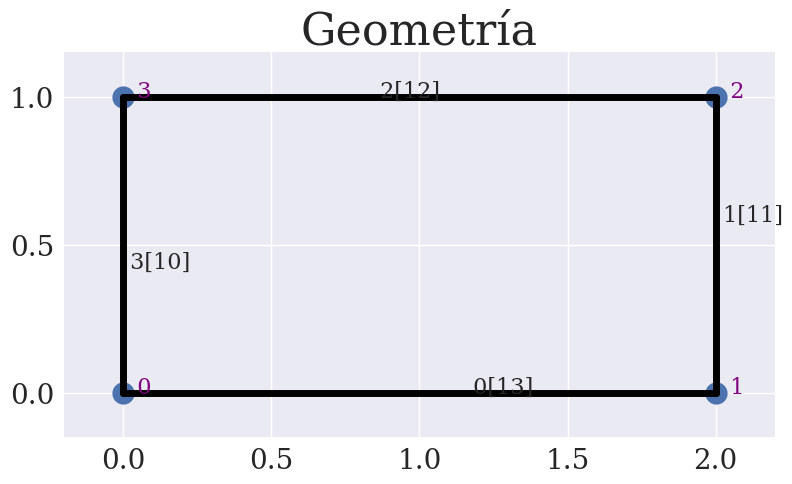

In [2]:
geometria = cfg.Geometry()

# puntos
geometria.point([0,0])      # 0
geometria.point([2,0])     # 1
geometria.point([2,1])     # 2
geometria.point([0,1])    # 3

# líneas
left = 10
right = 11
top = 12
bottom = 13

geometria.line([0,1], marker=bottom)       # 0
geometria.line([1,2], marker=right)       # 1
geometria.line([2,3], marker=top)       # 2
geometria.line([3,0], marker=left)    # 3

# superficies
mat0 = 0
geometria.surface([0,1,2,3], marker=mat0)

# gráfica de la geometría
cfv.figure(fig_size=(16,5))
cfv.title('Geometría', fontdict={"fontsize": 32})
cfv.draw_geometry(geometria, font_size=16, draw_axis=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

## Malla

Info    : GMSH -> Python-module


(array([-0.5,  0. ,  0.5,  1. ,  1.5]),
 [Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5')])

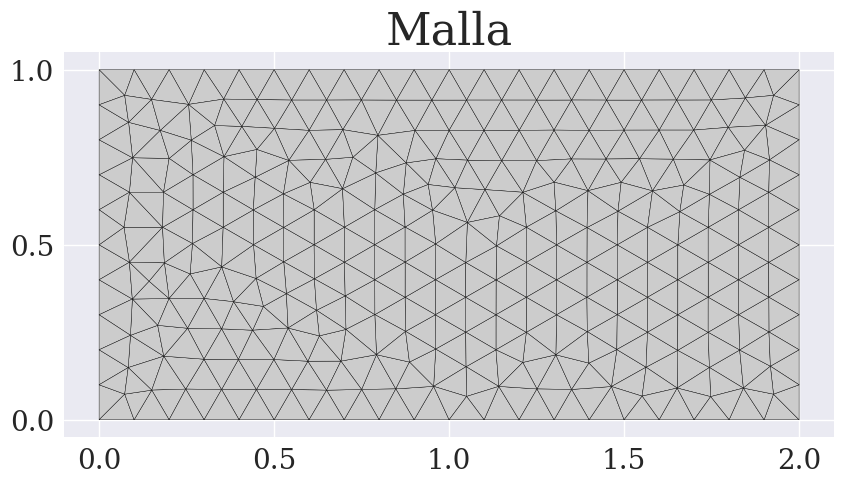

In [5]:
mesh = cfm.GmshMesh(geometria)

mesh.el_type = 2                            # type of element: 2 = triangle
mesh.dofs_per_node = 1
mesh.el_size_factor = 0.1

coords, edof, dofs, bdofs, elementmarkers = mesh.create()   # create the geometry
verts, faces, vertices_per_face, is_3d = cfv.ce2vf(
    coords,
    edof,
    mesh.dofs_per_node,
    mesh.el_type
)

# gráfica de la malla
cfv.figure(fig_size=(16,5))
cfv.title('Malla', fontdict={"fontsize": 32})
cfv.draw_mesh(
    coords=coords,
    edof=edof,
    dofs_per_node=mesh.dofs_per_node,
    el_type=mesh.el_type,
    filled=True
)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

## Identificación de las fronteras

(-0.1, 2.1, -0.05, 1.05)

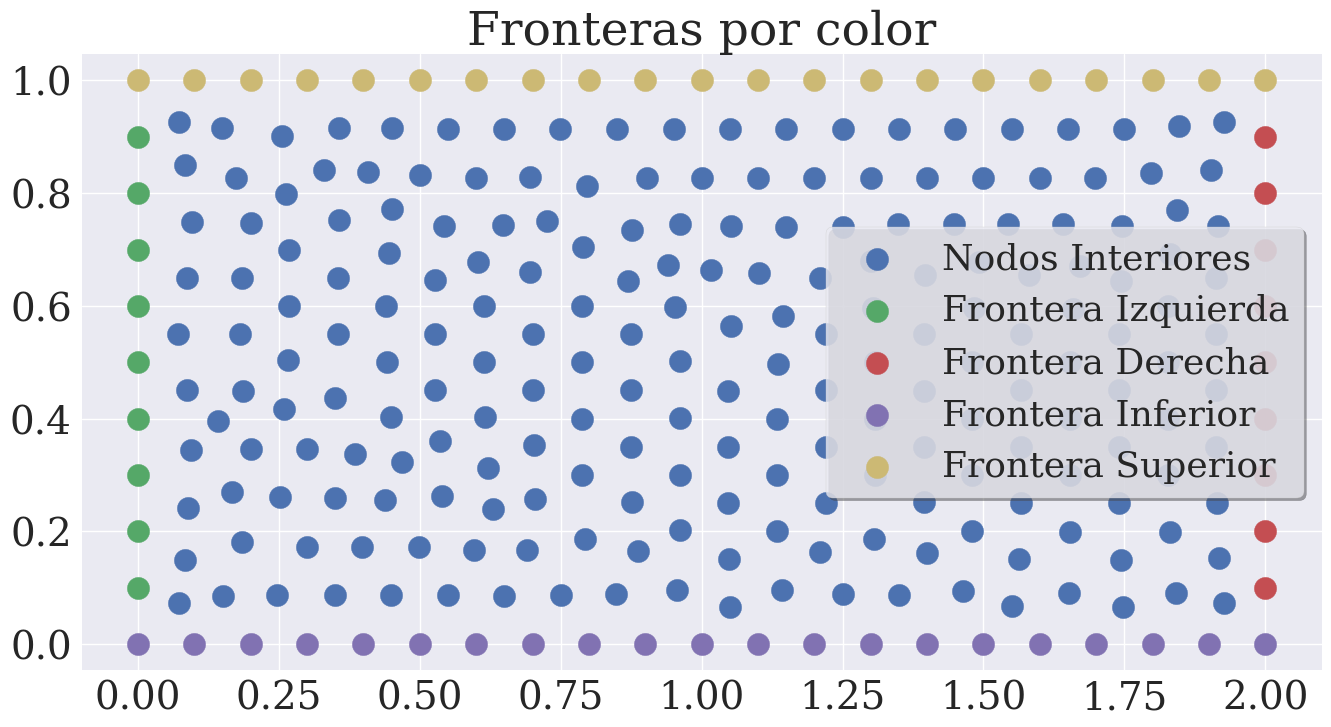

In [8]:
bleft = np.asarray(bdofs[left]) - 1
bleft = np.setdiff1d(bleft, [0,3])
bright = np.asarray(bdofs[right]) - 1
bright = np.setdiff1d(bright, [1,2])
bbottom = np.asarray(bdofs[bottom]) - 1
btop = np.asarray(bdofs[top]) - 1

fronteras = (bleft, bright, bbottom, btop)
interiores = np.setdiff1d(np.arange(coords.shape[0]) , np.hstack(fronteras))
etiquetas = (
    "Frontera Izquierda",
    "Frontera Derecha",
    "Frontera Inferior",
    "Frontera Superior"
)

from graficas import nodos_por_color
plt.figure(figsize=(16,8))
nodos_por_color(
    boundaries=fronteras,
    p=coords,
    labels=etiquetas,
    interior=interiores,
    label_interior="Nodos Interiores",
    alpha=1
)
plt.axis('equal')

## Parámetros del problema

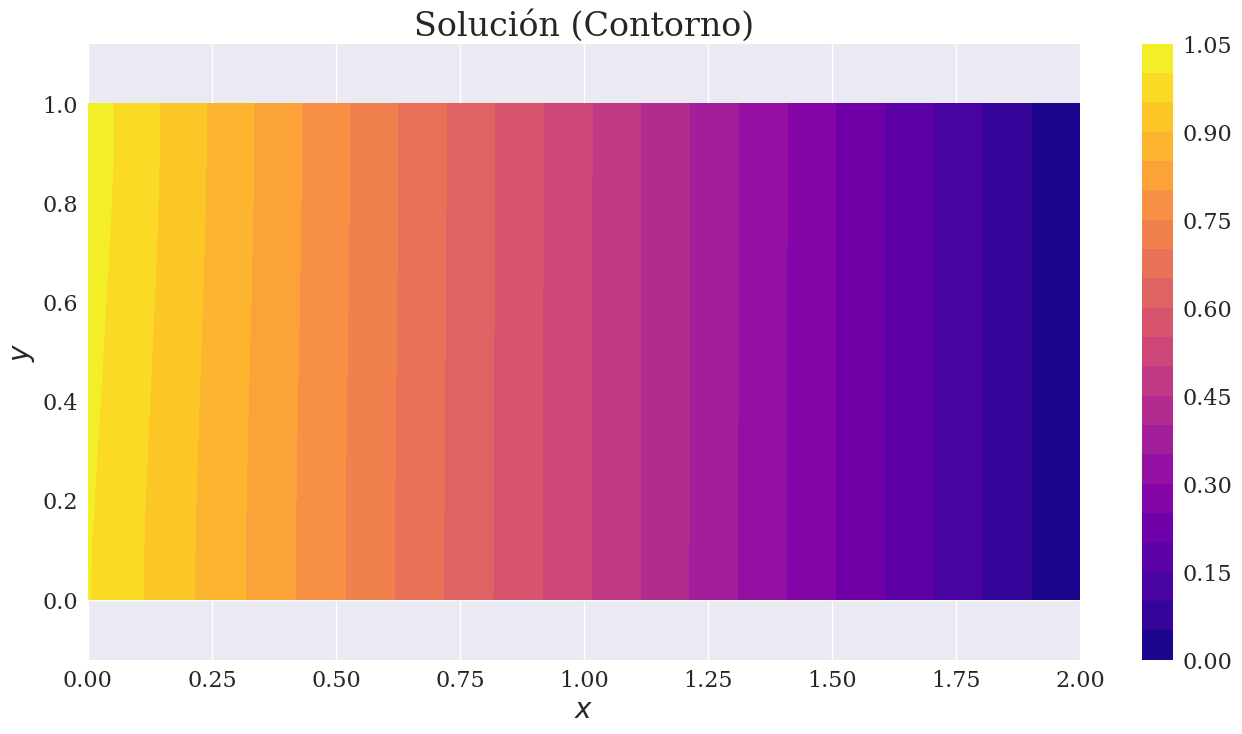

In [12]:
L = np.array([0,0,0,2,0,2])
k0 = lambda p: 1
f = lambda p:  0 #-0.001
ul = lambda p: 1 + 0.25 * np.sin(np.pi * p[1]/25)
ur = lambda p: 0
ub = lambda p: 0
ut = lambda p: 0

materials = {}
materials["0"] = [k0, interiores]

dirichlet_boundaries = {}
dirichlet_boundaries["left"] = [bleft, ul]
dirichlet_boundaries["right"] = [bright, ur]

neumann_boundaries = {}
neumann_boundaries["bottom"] = [k0, bbottom, ub]
neumann_boundaries["top"] = [k0, btop, ut]



from GFDM import create_system_K_F
K, F, U = create_system_K_F(
    p=coords,
    triangles=faces,
    L=L,
    source=f,
    materials=materials,
    neumann_boundaries=neumann_boundaries,
    dirichlet_boundaries=dirichlet_boundaries,
    interfaces={}
)

fig = plt.figure(figsize=(16,8))
plt.tricontourf(
    coords[:,0],
    coords[:,1],
    U,
    levels=20,
    cmap=mapa_de_color,
)
plt.colorbar()
plt.axis('equal')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Solución (Contorno)")

# plt.style.use("paper3dplot.mplstyle")
# fig = plt.figure(figsize=(10,8))
# ax = plt.axes(projection="3d")
# ax.plot_trisurf(
#     coords[:,0],
#     coords[:,1],
#     U,
#     cmap=mapa_de_color,
#     linewidth=1,
#     antialiased=False
# )
# ax.view_init(azim=-60, elev=50)

# plt.title("Solución (3D)")
# ax.set_xlabel("$x$")
# ax.set_ylabel("$y$")
# ax.set_zlabel("$u(x,y)$")

plt.show()